# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [6]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import io

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"
response = requests.get(url)
print("Estado:", response.status_code)

Estado: 200


In [7]:
html = io.StringIO(response.text)
tables = pd.read_html(html)
print(f"Se encontraron {len(tables)} tablas.")

Se encontraron 27 tablas.


In [8]:
df = tables[0]
df.sample(10,random_state=2025)

,Rank,Song,Artist(s),Streams (billions),Release date,Ref.
49,50,"""Stressed Out""",Twenty One Pilots,2.634,28 April 2015,[51]
77,78,"""Sad!""",XXXTentacion,2.374,2 March 2018,[79]
61,62,"""7 Rings""",Ariana Grande,2.519,18 January 2019,[63]
69,70,"""One Kiss""",Calvin Harris and Dua Lipa,2.440,6 April 2018,[71]
6,7,"""Sweater Weather""",The Neighbourhood,3.740,3 December 2012,[8]
96,97,"""Stay with Me""",Sam Smith,2.285,14 April 2014,[98]
68,69,"""Kill Bill""",SZA,2.468,9 December 2022,[70]
19,20,"""Take Me to Church""",Hozier,3.008,13 September 2013,[21]
2,3,"""Someone You Loved""",Lewis Capaldi,3.886,8 November 2018,[4]
5,6,"""Sunflower""",Post Malone and Swae Lee,3.796,18 October 2018,[7]


In [9]:
# Limpieza de datos

# Renombramos columnas si es necesario
df.columns = ["Rank", "Song", "Artist", "Streams (billions)", "Date released", "Reference"]

# Eliminamos notas entre corchetes
df["Song"] = df["Song"].str.replace(r"\[.*?\]", "", regex=True)
df["Artist"] = df["Artist"].str.replace(r"\[.*?\]", "", regex=True)

df = df[df["Streams (billions)"].astype(str).str.contains(r"^\d+(?:\.\d+)?$", na=False)].copy()

# Convertimos Streams a números flotantes
df["Streams (billions)"] = df["Streams (billions)"].astype(float)

# Convertimos fechas a datetime
df["Date released"] = pd.to_datetime(df["Date released"], errors="coerce")

df

,Rank,Song,Artist,Streams (billions),Date released,Reference
0,1,"""Blinding Lights""",The Weeknd,4.817,2019-11-29,[2]
1,2,"""Shape of You""",Ed Sheeran,4.337,2017-01-06,[3]
2,3,"""Someone You Loved""",Lewis Capaldi,3.886,2018-11-08,[4]
3,4,"""Starboy""",The Weeknd and Daft Punk,3.868,2016-09-21,[5]
4,5,"""As It Was""",Harry Styles,3.856,2022-04-01,[6]
...,...,...,...,...,...,...
95,96,"""Too Good at Goodbyes""",Sam Smith,2.294,2017-09-08,[97]
96,97,"""Stay with Me""",Sam Smith,2.285,2014-04-14,[98]
97,98,"""Someone Like You""",Adele,2.278,2011-01-24,[99]
98,99,"""Havana""",Camila Cabello and Young Thug,2.272,2017-08-03,[100]


### Almacenar datos en sqlite


In [10]:
conn = sqlite3.connect("spotify_top_songs.db")

In [12]:
df.to_sql("most_streamed", conn, if_exists="replace", index=False)
cursor = conn.cursor()
cursor.execute("SELECT COUNT(*) FROM most_streamed")
print("Rows inserted:", cursor.fetchone()[0])

conn.commit()
conn.close()

Rows inserted: 100


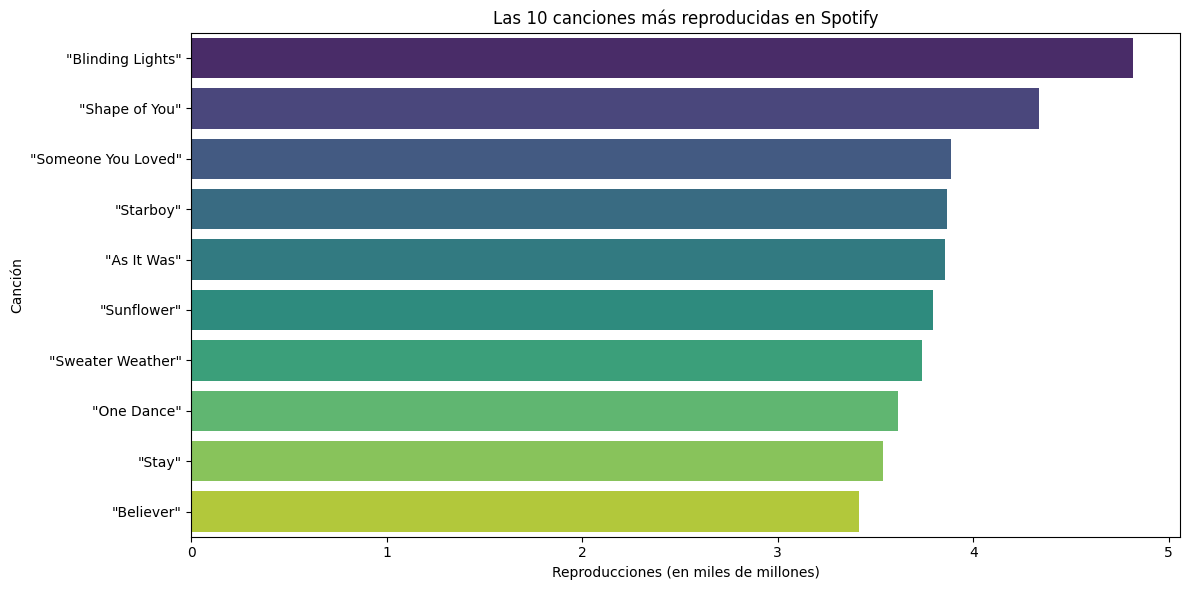

In [13]:
top10 = df.nlargest(10, "Streams (billions)")
plt.figure(figsize=(12, 6))
sns.barplot(data=top10, x="Streams (billions)", y="Song", hue="Song", palette="viridis", legend=False)
plt.title("Las 10 canciones más reproducidas en Spotify")
plt.xlabel("Reproducciones (en miles de millones)")
plt.ylabel("Canción")
plt.tight_layout()
plt.show()

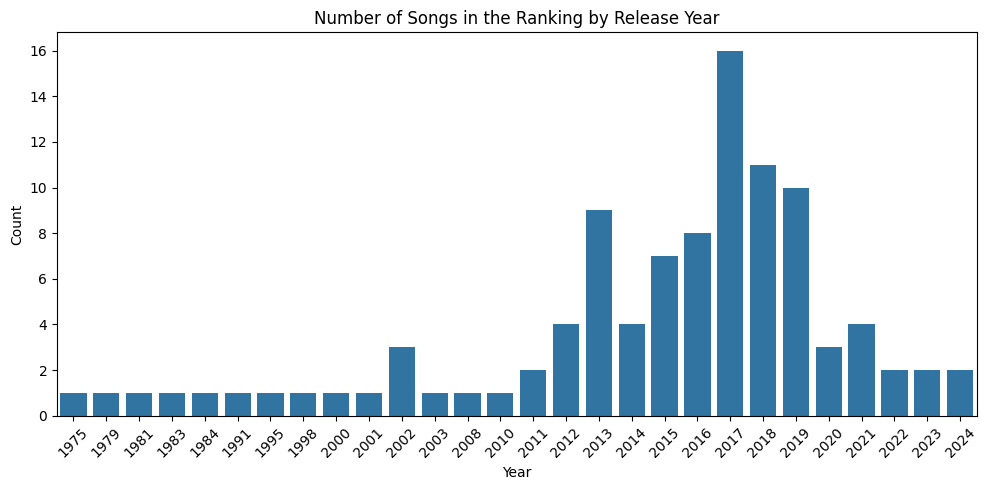

In [14]:
df["Year"] = df["Date released"].dt.year
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="Year", order=sorted(df["Year"].dropna().unique()))
plt.title("Number of Songs in the Ranking by Release Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

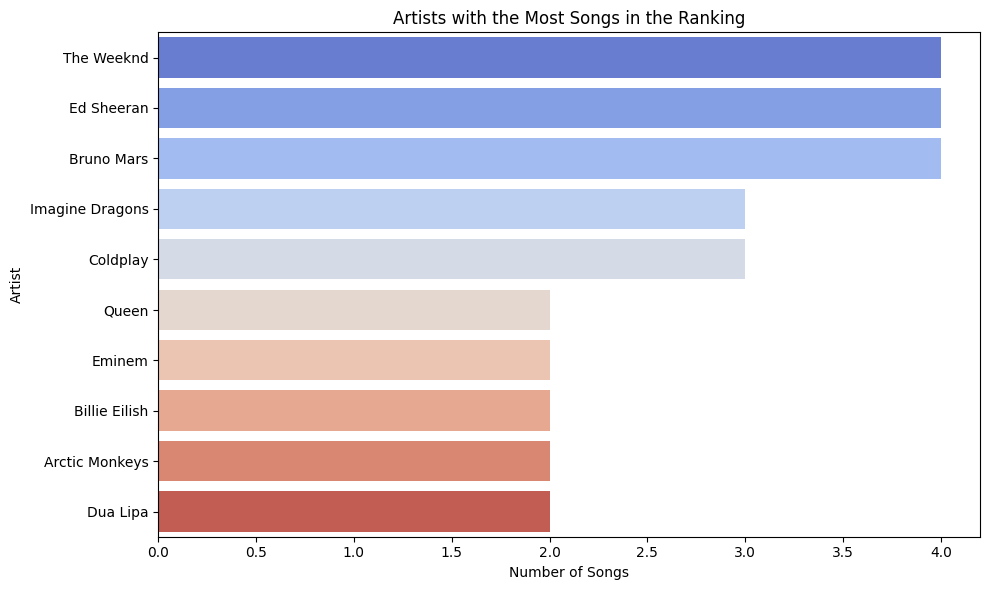

In [15]:
artists = df["Artist"].value_counts().nlargest(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=artists.values, y=artists.index, hue=artists.index, palette="coolwarm", legend=False)
plt.title("Artists with the Most Songs in the Ranking")
plt.xlabel("Number of Songs")
plt.ylabel("Artist")
plt.tight_layout()
plt.show()